# Inferencing SSD ONNX model using ONNX Runtime Server

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

SSD is a state-of-the-art object detection model that enables users to identify individual objects in an image, and place bounding boxes around them.

This tutorial uses the Open Neural Network eXchange (ONNX) machine learning model format to show the simplest way to take a pretrained SSD model and start experimenting with object detection. To run through this notebook, you'll need a few dependencies that you can install with the commands below.

## Dependencies

NumPy for data data manipulation:

1) pip install numpy

PIL and Matplotlib for raw image manipulation and inline display:

2) pip install pillow

3) pip install matplotlib

## Pre-requisites to run the notebook

1) Please download the SSD ONNX model (ssd.onnx) file from [here](https://onnxzoo.blob.core.windows.net/models/opset_10/ssd/ssd.onnx)

For example, you could do `wget https://onnxzoo.blob.core.windows.net/models/opset_10/ssd/ssd.onnx` if you have `wget` installed, or you could download the model directly by visiting the referenced URL. 

2) Please download the ONNXRuntime Server image:

`sudo docker pull mcr.microsoft.com/onnxruntime/server`

3) In the same folder as the downloaded `ssd.onnx` file, please run (to be run on Linux, for Windows you must use WSL):

`sudo docker run -it -v $(pwd):$(pwd) -p 9001:8001 mcr.microsoft.com/onnxruntime/server --model_path $(pwd)/ssd.onnx` 

(In case of errors like port already allocated etc., please only change the number 9001 to something else (keeping 8001 as is). Please remember the changed port number as it will be be needed to modify the URL where the HTTP request is actually sent. Instructions will be present in python comments in the appropriate Jupyter cell.) 

## Some additional information

In the `assets` folder, there are 2 `proto` files and the corresponding compiled source code files `_pb2.py` required by this notebook. The proto files were [compiled using protoc](https://developers.google.com/protocol-buffers/docs/pythontutorial). More details regarding ONNX Runtime server are present in `ONNX_Runtime_Server_Usage.md` [here](https://github.com/microsoft/onnxruntime/blob/master/docs/).  


### Importing libraries
After all pre-requisites have been taken care of, let's start off with running the notebook. In the upcoming cell, we will be importing a few libraries needed for us to run the notebook. You will notice a few familiar libraries having just installed them as part of the pre-requisites. 

In [1]:
# Import some dependency libraries that we are going to need to run the SSD model

import numpy as np
import assets.onnx_ml_pb2 as onnx_ml_pb2
import assets.predict_pb2 as predict_pb2
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Load the input image
Next, let's load the raw image that we are going to run the SSD model on. Using some library routines we are going to resize the raw image to be 1200 x 1200 as that is the accepted input size by the model.

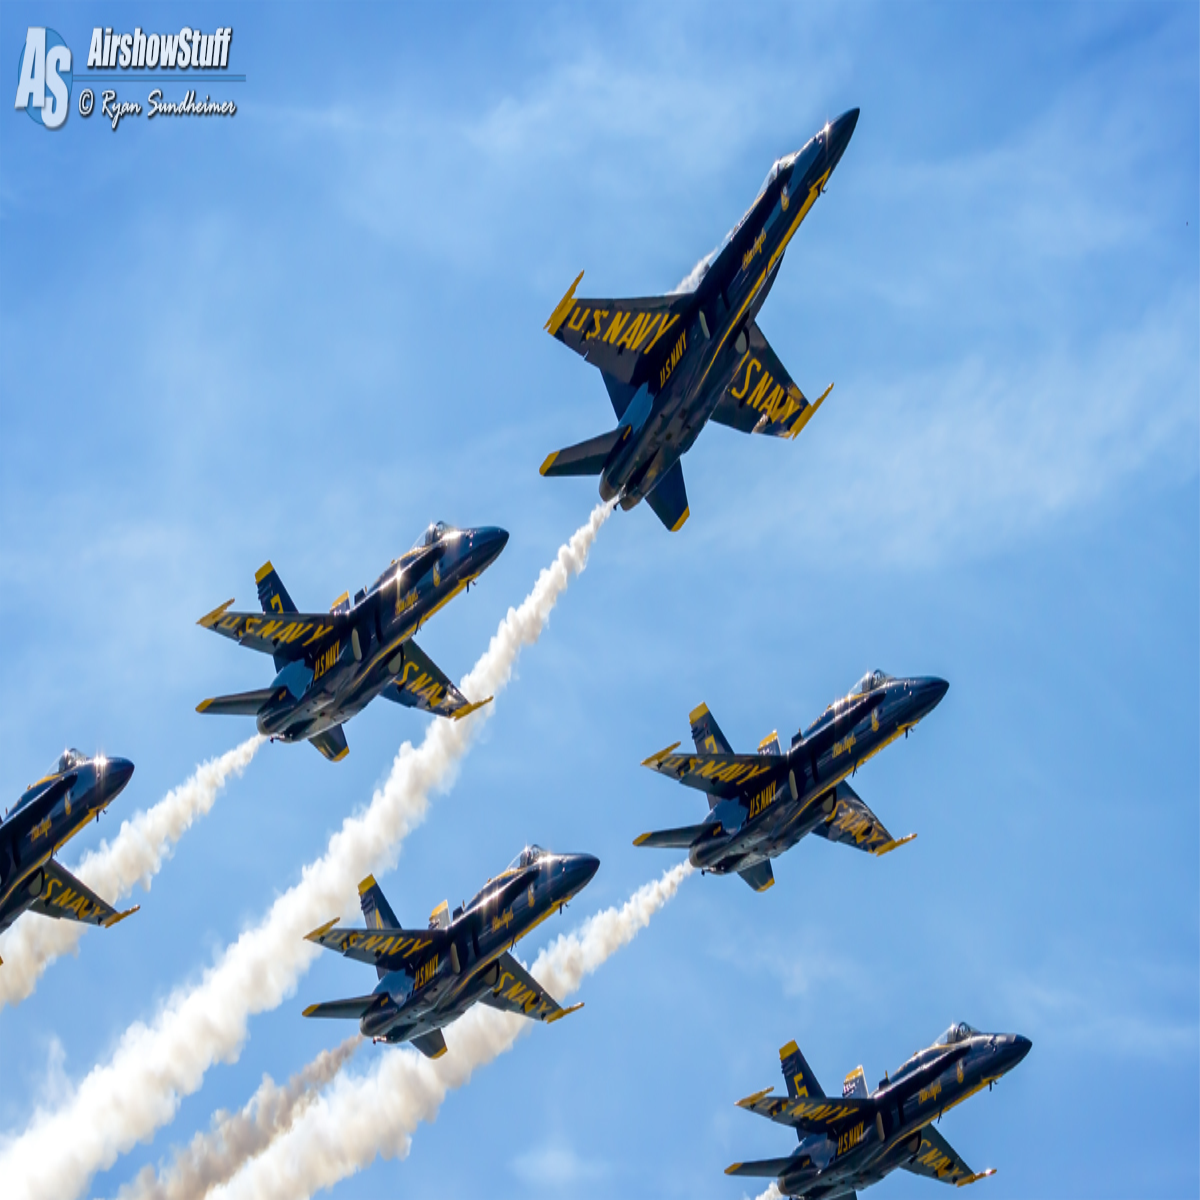

In [2]:
# Load the raw image

input_shape = (1, 3, 1200, 1200)
img = Image.open("assets/blueangels.jpg")
img = img.resize((1200, 1200), Image.BILINEAR)

# Let us see what the input image looks like
img

### Pre-process the input image
Having loaded and resized the raw image to fit the model's requirements, we are further going to pre-process the image to take it to a state that the model has seen before as part of the "training" phase of the model.

In [3]:
# Preprocess and normalize the image

img_data = np.array(img)
img_data = np.transpose(img_data, [2, 0, 1])
img_data = np.expand_dims(img_data, 0)
mean_vec = np.array([0.485, 0.456, 0.406])
stddev_vec = np.array([0.229, 0.224, 0.225])
norm_img_data = np.zeros(img_data.shape).astype('float32')
for i in range(img_data.shape[1]):
    norm_img_data[:,i,:,:] = (img_data[:,i,:,:]/255 - mean_vec[i]) / stddev_vec[i]

### Construct an HTTP request for the ORT server
Now that we have an image that has undergone sufficient pre-processing for the model to process, we are going to "serialize" the image data to be sent over to the ORT Server that you just started as part of the pre-requisites. We are going to create an "HTTP request" that contains the image data that will be processed by the model hosted using the ORT server.

In [4]:
# Create request message to be sent to the ORT server

input_tensor = onnx_ml_pb2.TensorProto()
input_tensor.dims.extend(norm_img_data.shape)
input_tensor.data_type = 1
input_tensor.raw_data = norm_img_data.tobytes()

request_message = predict_pb2.PredictRequest()

# For your model, the inputs name should be something else customized by yourself. Use Netron to find out the input name.
request_message.inputs["image"].data_type = input_tensor.data_type
request_message.inputs["image"].dims.extend(input_tensor.dims)
request_message.inputs["image"].raw_data = input_tensor.raw_data

content_type_headers = ['application/x-protobuf', 'application/octet-stream', 'application/vnd.google.protobuf']

for h in content_type_headers:
    request_headers = {
        'Content-Type': h,
        'Accept': 'application/x-protobuf'
    }

### Make the HTTP request to the ORT server
Remember the HTTP request we just constructed ? We are going to actually make the constructed request so that the ORT server can receive the image data to be processed. The ORT server then sends the raw image data to the model hosted by it and waits for the inference results. Once the server gets back the inference results, it is going to relay it back to the caller (this notebook).

In [5]:
# Inference run using ORT server
# Change the number 9001 to the appropriate port number if you had changed it during ORT Server docker instantiation

PORT_NUMBER = 9001 # Change appropriately if needed based on any changes when invoking the server in the pre-requisites
inference_url = "http://127.0.0.1:" + str(PORT_NUMBER) + "/v1/models/default/versions/1:predict"
response = requests.post(inference_url, headers=request_headers, data=request_message.SerializeToString())

### Parse the response message from the ORT server
Having received the results from the server, we are going to parse the "serialized" message that we just received for us to make sense of the results. 

In [6]:
# Parse response message

response_message = predict_pb2.PredictResponse()
response_message.ParseFromString(response.content)

# For your model, the outputs names should be something else customized by yourself. Use Netron to find out the outputs names.
bboxes = np.frombuffer(response_message.outputs['bboxes'].raw_data, dtype=np.float32)
labels = np.frombuffer(response_message.outputs['labels'].raw_data, dtype=np.int64)
scores = np.frombuffer(response_message.outputs['scores'].raw_data, dtype=np.float32)

print('Boxes shape:', response_message.outputs['bboxes'].dims)
print('Labels shape:', response_message.outputs['labels'].dims)
print('Scores shape:', response_message.outputs['scores'].dims)

Boxes shape: [1, 200, 4]
Labels shape: [1, 200]
Scores shape: [1, 200]


### Annotate the input image with results
Now that we have the results, let use annotate the input image with the objects detected and the appropriate object category. 

<Figure size 432x288 with 0 Axes>

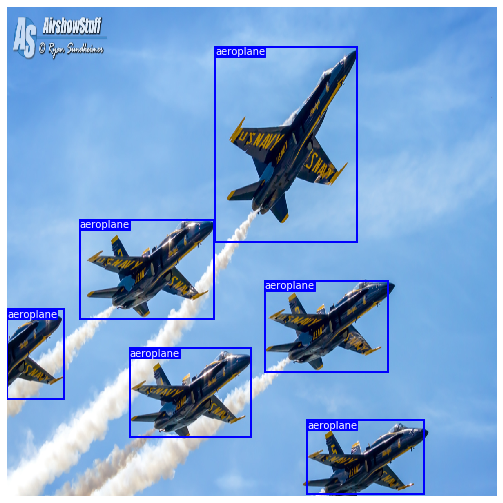

In [7]:
## Display image with bounding boxes and appropriate class 

# Parse the list of class labels
classes = [line.rstrip('\n') for line in open('assets/coco_classes.txt')]

# Plot the bounding boxes on the image
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

resized_width = 1200  # we resized the original image, remember ? 
resized_height = 1200
num_boxes = 6 # we limit displaying to just 10 boxes to avoid clogging the result image with boxes
               # The results are already sorted based on box confidences, so we just pick top N boxes without sorting
    
for c in range(num_boxes):    
    base_index = c * 4
    y1, x1, y2, x2 = bboxes[base_index] * resized_height, bboxes[base_index + 1] * resized_width, bboxes[base_index + 2] * resized_height, bboxes[base_index + 3] * resized_width 
    color = 'blue'
    box_h = (y2 - y1)
    box_w = (x2 - x1)
    bbox = patches.Rectangle((y1, x1), box_h, box_w, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(bbox)
    plt.text(y1, x1, s=classes[labels[c] - 1], color='white', verticalalignment='top', bbox={'color': color, 'pad': 0})
plt.axis('off')

# Save image
plt.savefig("output/ssd_result.jpg", bbox_inches='tight', pad_inches=0.0)
plt.show()
